## 公式Example

深層学習フレームワークには公式に様々なモデルのExampleコードが公開されています。

### 【問題1】公式チュートリアルモデルを分担して実行
TensorFLowの公式チュートリアルモデルを分担して実行してください。

以下の中から1人ひとつ選び実行し、その結果を簡単に発表してください。

[models/tutorials at master · tensorflow/models](https://www.tensorflow.org/tutorials/)

## [統合された勾配(Integrated Gradients)](https://www.tensorflow.org/tutorials/interpretability/integrated_gradients)

[Integrated Gradientsについてのわかりやすい記事](https://qrunch.net/@opqrstuvcut/entries/FKxqQpXc0lhh3LMn)

- Integrated Gradientsとは？

ディープラーニングのモデルを評価する手法のひとつ。補完定数を変化させたときの勾配を全て足し合わせることで重要な特徴量が見えてくる。特徴量の重要性やモデルの妥当性を測るなどのユースケースがある。

In [1]:
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.python.client import device_lib
print(tf.__version__)

2.0.2


In [2]:
model = tf.keras.Sequential([
                             hub.KerasLayer(name='inception_v1', 
                                            handle='https://tfhub.dev/google/imagenet/inception_v1/classification/4', 
                                            trainable=False),
                             ])
model.build([None, 224, 224, 3])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v1 (KerasLayer)    multiple                  6633209   
Total params: 6,633,209
Trainable params: 0
Non-trainable params: 6,633,209
_________________________________________________________________


In [3]:
def load_imagenet_labels(file_path):
    labels_file = tf.keras.utils.get_file('ImageNetLabels.txt', file_path)
    with open(labels_file) as reader:
        f = reader.read()
        labels = f.splitlines()
    return np.array(labels)

In [4]:
imagenet_labels = load_imagenet_labels('https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')

In [5]:
def read_image(file_name):
    image = tf.io.read_file(file_name)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize_with_pad(image, target_height=224, target_width=224)
#     image = tf.image.resize(image, [224,224])
    return image

In [6]:
img_url = {
    'Fireboat': 'http://storage.googleapis.com/download.tensorflow.org/example_images/San_Francisco_fireboat_showing_off.jpg',
    'Giant Panda': 'http://storage.googleapis.com/download.tensorflow.org/example_images/Giant_Panda_2.jpeg',
}

img_paths = {name: tf.keras.utils.get_file(name, url) for (name, url) in img_url.items()}
img_name_tensors = {name: read_image(img_path) for (name, img_path) in img_paths.items()}

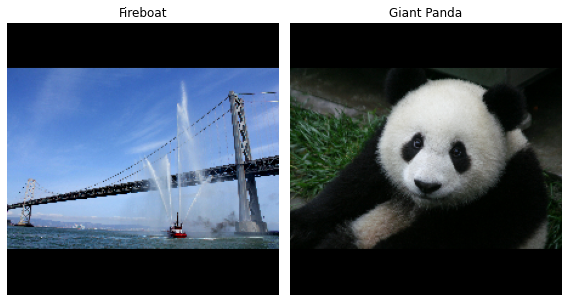

In [7]:
plt.figure(figsize=(8, 8))
for n, (name, img_tensors) in enumerate(img_name_tensors.items()):
    ax = plt.subplot(1, 2, n+1)
    ax.imshow(img_tensors)
    ax.set_title(name)
    ax.axis('off')
plt.tight_layout()

In [8]:
def top_k_predictions(img, k=3):
    image_batch = tf.expand_dims(img, 0)
    predictions = model(image_batch)
    probs = tf.nn.softmax(predictions, axis=-1)
    top_probs, top_idxs = tf.math.top_k(input=probs, k=k)
    top_labels = imagenet_labels[tuple(top_idxs)]
    return top_labels, top_probs[0]

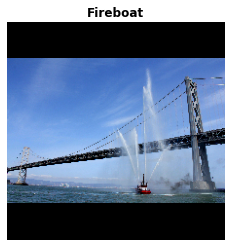

fireboat: 32.6%
pier: 12.7%
suspension bridge: 5.7%


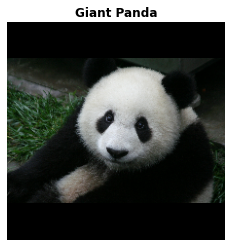

giant panda: 89.4%
teddy: 0.3%
gibbon: 0.3%


In [9]:
for (name, img_tensor) in img_name_tensors.items():
    plt.imshow(img_tensor)
    plt.title(name, fontweight='bold')
    plt.axis('off')
    plt.show()

    pred_label, pred_prob = top_k_predictions(img_tensor)
    for label, prob in zip(pred_label, pred_prob):
        print(f'{label}: {prob:0.1%}')

In [10]:
def f(x):
    """A simplified model function."""
    return tf.where(x < 0.8, x, 0.8)

def interpolated_path(x):
    """A straight line path."""
    return tf.zeros_like(x)

x = tf.linspace(start=0.0, stop=1.0, num=6)
y = f(x)

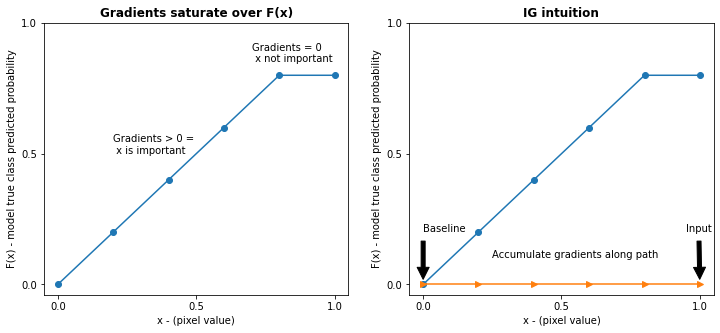

In [11]:
fig = plt.figure(figsize=(12, 5))
ax0 = fig.add_subplot(121)
ax0.plot(x.numpy(), y.numpy(), marker='o')
ax0.set_title('Gradients saturate over F(x)', fontweight='bold')
ax0.text(0.2, 0.5, 'Gradients > 0 = \n x is important')
ax0.text(0.7, 0.85, 'Gradients = 0 \n x not important')
ax0.set_yticks(tf.range(0, 1.5, 0.5))
ax0.set_xticks(tf.range(0, 1.5, 0.5))
ax0.set_ylabel('F(x) - model true class predicted probability')
ax0.set_xlabel('x - (pixel value)')

ax1 = fig.add_subplot(122)
ax1.plot(x, f(x), marker='o')
ax1.plot(x, interpolated_path(x), marker='>')
ax1.set_title('IG intuition', fontweight='bold')
ax1.text(0.25, 0.1, 'Accumulate gradients along path')
ax1.set_ylabel('F(x) - model true class predicted probability')
ax1.set_xlabel('x - (pixel value)')
ax1.set_yticks(tf.range(0, 1.5, 0.5))
ax1.set_xticks(tf.range(0, 1.5, 0.5))
ax1.annotate('Baseline', xy=(0.0, 0.0), xytext=(0.0, 0.2),
             arrowprops=dict(facecolor='black', shrink=0.1))
ax1.annotate('Input', xy=(1.0, 0.0), xytext=(0.95, 0.2),
             arrowprops=dict(facecolor='black', shrink=0.1))
plt.show()

In [12]:
baseline = tf.zeros(shape=(224,224,3))

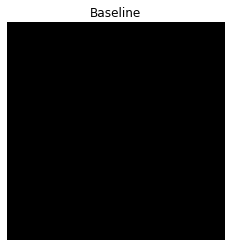

In [13]:
plt.imshow(baseline)
plt.title("Baseline")
plt.axis('off')
plt.show()

Integrated Gradientsの式は以下の通り。
$$
IG_i(x)::=(x_i-x'_i)×\int^1_{\alpha=0}\frac{\partial F(x'+\alpha×(x-x'))}{\partial x_i}d\alpha
$$

$i$:特徴

$x$:入力

$x'$:ベースライン

$\alpha$:特徴を摂動するための補間定数

実際には、定積分の計算は常に数値的に可能であるとは限らず、計算コストがかかる可能性があるため、次の数値近似を計算します。
$$
IG_i^{approx}(x)::=(x_i-x'_i)×\sum^m_{k=1}\frac{\partial F(\overbrace{x'+\frac{k}{m}×(x-x')}^{k個の間隔でm個の画像を補間})}{\partial x_i}×\frac{1}{m}
$$

$i$:特徴(個々のピクセル)

$x$:入力(画像テンソル)

$x'$:ベースライン(画像テンソル)

$k$:スケーリングされた特徴摂動定数

$m$:積分の[リーマン和](https://www1.doshisha.ac.jp/~kmizoha/analysis1/Lecture6.pdf)近似のステップ数

In [14]:
m_steps=50
alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1) # Generate m_steps intervals for integral_approximation() below.

In [15]:
def interpolate_images(baseline,
                       image,
                       alphas):
    alphas_x = alphas[:, tf.newaxis, tf.newaxis, tf.newaxis]
    baseline_x = tf.expand_dims(baseline, axis=0)
    input_x = tf.expand_dims(image, axis=0)
    delta = input_x - baseline_x
    images = baseline_x +  alphas_x * delta
    return images

In [16]:
interpolated_images = interpolate_images(
    baseline=baseline,
    image=img_name_tensors['Fireboat'],
    alphas=alphas)

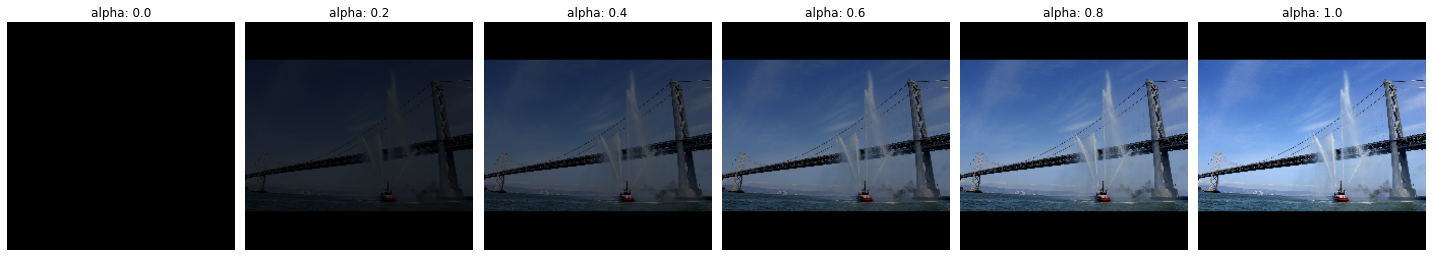

In [17]:
fig = plt.figure(figsize=(20, 20))

i = 0
for alpha, image in zip(alphas[0::10], interpolated_images[0::10]):
    i += 1
    plt.subplot(1, len(alphas[0::10]), i)
    plt.title(f'alpha: {alpha:.1f}')
    plt.imshow(image)
    plt.axis('off')

plt.tight_layout();

In [18]:
def compute_gradients(images, target_class_idx):
    with tf.GradientTape() as tape:
        tape.watch(images)
        logits = model(images)
        probs = tf.nn.softmax(logits, axis=-1)[:, target_class_idx]
    return tape.gradient(probs, images)

In [19]:
path_gradients = compute_gradients(
    images=interpolated_images,
    target_class_idx=555)

In [20]:
print(path_gradients.shape)

(51, 224, 224, 3)


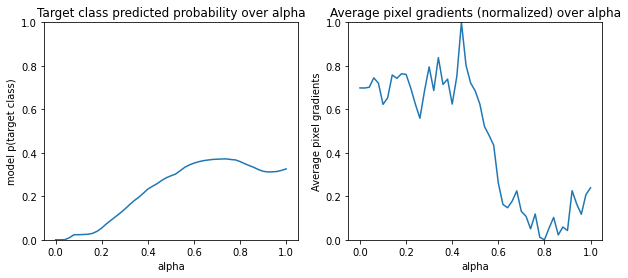

In [21]:
pred = model(interpolated_images)
pred_proba = tf.nn.softmax(pred, axis=-1)[:, 555]

plt.figure(figsize=(10, 4))
ax1 = plt.subplot(1, 2, 1)
ax1.plot(alphas, pred_proba)
ax1.set_title('Target class predicted probability over alpha')
ax1.set_ylabel('model p(target class)')
ax1.set_xlabel('alpha')
ax1.set_ylim([0, 1])

ax2 = plt.subplot(1, 2, 2)
# Average across interpolation steps
average_grads = tf.reduce_mean(path_gradients, axis=[1, 2, 3])
# Normalize gradients to 0 to 1 scale. E.g. (x - min(x))/(max(x)-min(x))
average_grads_norm = (average_grads-tf.math.reduce_min(average_grads))/(tf.math.reduce_max(average_grads)-tf.reduce_min(average_grads))
ax2.plot(alphas, average_grads_norm)
ax2.set_title('Average pixel gradients (normalized) over alpha')
ax2.set_ylabel('Average pixel gradients')
ax2.set_xlabel('alpha')
ax2.set_ylim([0, 1]);

In [22]:
def integral_approximation(gradients):
    # riemann_trapezoidal
    grads = (gradients[:-1] + gradients[1:]) / tf.constant(2.0)
    integrated_gradients = tf.math.reduce_mean(grads, axis=0)
    return integrated_gradients

In [23]:
ig = integral_approximation(
    gradients=path_gradients)

In [24]:
print(ig.shape)

(224, 224, 3)


In [25]:
# CPU, GPUデバイス確認用
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 8249018400980590141,
 name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 7740357786148539835
 physical_device_desc: "device: XLA_CPU device",
 name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 8932739996417370424
 physical_device_desc: "device: XLA_GPU device",
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 7559200768
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 15787517523110033613
 physical_device_desc: "device: 0, name: GeForce GTX 1070 with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 6.1"]

In [26]:
@tf.function
def integrated_gradients(baseline,
                         image,
                         target_class_idx,
                         m_steps=50,
                         batch_size=32):
    with tf.device("/device:CPU:0"):
        # 1. Generate alphas.
        alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1)

        # Initialize TensorArray outside loop to collect gradients.    
        gradient_batches = tf.TensorArray(tf.float32, size=m_steps+1)

        # Iterate alphas range and batch computation for speed, memory efficiency, and scaling to larger m_steps.
        for alpha in tf.range(0, len(alphas), batch_size):
            from_ = alpha
            to = tf.minimum(from_ + batch_size, len(alphas))
            alpha_batch = alphas[from_:to]

            # 2. Generate interpolated inputs between baseline and input.
            interpolated_path_input_batch = interpolate_images(baseline=baseline,
                                                               image=image,
                                                               alphas=alpha_batch)

            # 3. Compute gradients between model outputs and interpolated inputs.
            gradient_batch = compute_gradients(images=interpolated_path_input_batch,
                                               target_class_idx=target_class_idx)

            # Write batch indices and gradients to extend TensorArray.
            gradient_batches = gradient_batches.scatter(tf.range(from_, to), gradient_batch)    

        # Stack path gradients together row-wise into single tensor.
        total_gradients = gradient_batches.stack()

        # 4. Integral approximation through averaging gradients.
        avg_gradients = integral_approximation(gradients=total_gradients)

        # 5. Scale integrated gradients with respect to input.
        integrated_gradients = (image - baseline) * avg_gradients

        return integrated_gradients

In [27]:
ig_attributions = integrated_gradients(baseline=baseline,
                                       image=img_name_tensors['Fireboat'],
                                       target_class_idx=555,
                                       m_steps=240)

In [28]:
print(ig_attributions.shape)

(224, 224, 3)


In [29]:
def plot_img_attributions(baseline,
                          image,
                          target_class_idx,
                          m_steps=50,
                          cmap=None,
                          overlay_alpha=0.4):

    attributions = integrated_gradients(baseline=baseline,
                                      image=image,
                                      target_class_idx=target_class_idx,
                                      m_steps=m_steps)

    # Sum of the attributions across color channels for visualization.
    # The attribution mask shape is a grayscale image with height and width
    # equal to the original image.
    attribution_mask = tf.reduce_sum(tf.math.abs(attributions), axis=-1)

    fig, axs = plt.subplots(nrows=2, ncols=2, squeeze=False, figsize=(8, 8))

    axs[0, 0].set_title('Baseline image')
    axs[0, 0].imshow(baseline)
    axs[0, 0].axis('off')

    axs[0, 1].set_title('Original image')
    axs[0, 1].imshow(image)
    axs[0, 1].axis('off')

    axs[1, 0].set_title('Attribution mask')
    axs[1, 0].imshow(attribution_mask, cmap=cmap)
    axs[1, 0].axis('off')

    axs[1, 1].set_title('Overlay')
    axs[1, 1].imshow(attribution_mask, cmap=cmap)
    axs[1, 1].imshow(image, alpha=overlay_alpha)
    axs[1, 1].axis('off')

    plt.tight_layout()
    return fig

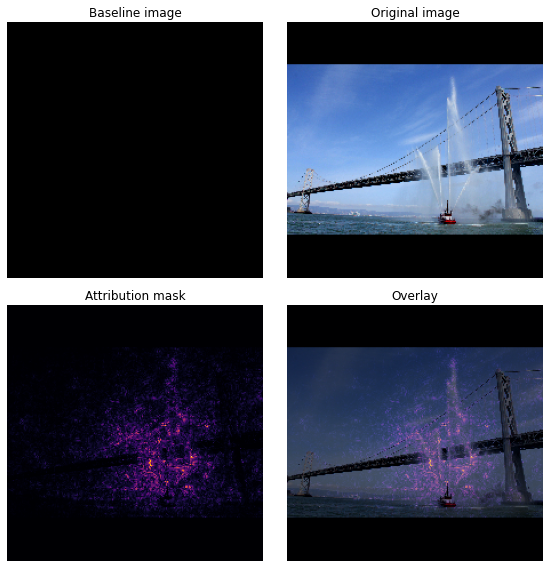

In [30]:
_ = plot_img_attributions(image=img_name_tensors['Fireboat'],
                          baseline=baseline,
                          target_class_idx=555,
                          m_steps=240,
                          cmap=plt.cm.inferno,
                          overlay_alpha=0.4)

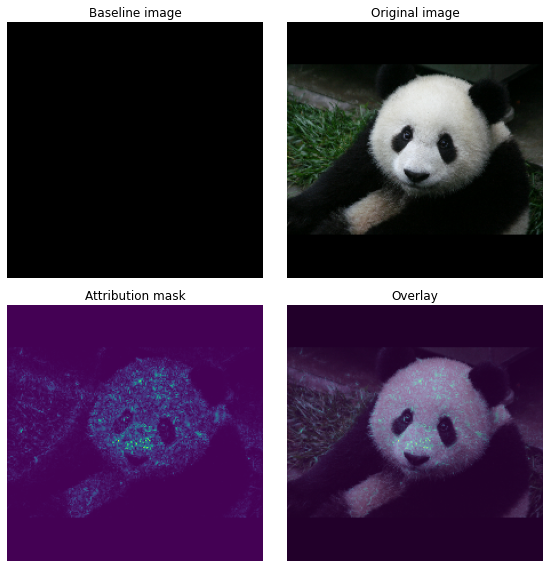

In [31]:
_ = plot_img_attributions(image=img_name_tensors['Giant Panda'],
                          baseline=baseline,
                          target_class_idx=389,
                          m_steps=55,
                          cmap=plt.cm.viridis,
                          overlay_alpha=0.5)

#### ユースケース
- モデルをデプロイする前にIntegrated Gradientsなどの手法を採用すると、モデルが機能する方法と理由を直感的に理解できるようになります。この手法で強調表示された機能はあなたの直感と一致していますか？そうでない場合は、モデルまたはデータセットのバグ、または過剰適合を示している可能性があります。

#### 制限事項
- Integrated Gradientsは、個々の例に特徴の重要性を提供しますが、データセット全体にわたるグローバルな特徴の重要性は提供しません。
- Integrated Gradientsは、個々の特徴の重要性を提供しますが、特徴の相互作用や組み合わせについては説明していません。

### 【問題2】（アドバンス課題）様々な手法を実行
TensorFLowやGoogle AI ResearchのGitHubリポジトリには、定番のモデルから最新のモデルまで多様なコードが公開されています。これらから興味あるものを選び実行してください。

なお、これらのコードは初学者向けではないため、巨大なデータセットのダウンロードが必要な場合など、実行が簡単ではないこともあります。そういった場合は、コードリーディングを行ってください。

[models/research at master · tensorflow/models](https://github.com/tensorflow/models/tree/master/research)

[google-research/google-research: Google AI Research](https://github.com/google-research/google-research)

更新日が古いものはPythonやTensorFlowのバージョンが古く、扱いずらい場合があります。新しいものから見ることを推奨します。

#### 回答なし

## 異なるフレームワークへの書き換え

「ディープラーニングフレームワーク1」で作成した4種類のデータセットを扱うTensorFLowのコードを異なるフレームワークに変更していきます。

- Iris（Iris-versicolorとIris-virginicaのみの2値分類）
- Iris（3種類全ての目的変数を使用して多値分類）
- House Prices
- MNIST

#### Kerasへの書き換え
KerasはTensorFLowに含まれるtf.kerasモジュールを使用してください。

KerasにはSequentialモデルかFunctional APIかなど書き方に種類がありますが、これは指定しません。

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.models import Model
from sklearn.preprocessing import Binarizer, OneHotEncoder, StandardScaler
import keras.backend as K
import tensorflow as tf
from sklearn.metrics import r2_score
from keras.datasets import mnist

Using TensorFlow backend.


### 【問題3】Iris（2値分類）をKerasで学習
TensorFlowによるIrisデータセットに対する2値分類をKerasに書き換えてください。

In [33]:
# データセットの読み込み
dataset_path ="Iris.csv"
df = pd.read_csv(dataset_path)
# データフレームから条件抽出
df = df[(df["Species"] == "Iris-versicolor")|(df["Species"] == "Iris-virginica")]
y = df["Species"]
X = df.loc[:, ["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"]]
y = np.array(y)
X = np.array(X)
# ラベルを数値に変換
y[y=='Iris-versicolor'] = 0
y[y=='Iris-virginica'] = 1
y = y.astype(np.int)[:, np.newaxis]
# trainとtestに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

layer_input = Input(shape=(4,), name='input')
layer_dense1 = Dense(50, activation='relu', kernel_initializer='he_uniform', bias_initializer='zeros')
layer_dense2 = Dense(100, activation='relu', kernel_initializer='he_uniform', bias_initializer='zeros')
layer_dense3 = Dense(1, activation='sigmoid')

x = layer_input
dense1 = layer_dense1(x)
dense2 = layer_dense2(dense1)
y = layer_dense3(dense2)
model = Model(inputs=x, outputs=y)
model.compile(optimizer='adam', loss_weights=[0.01],
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(x=X_train, y=y_train, 
          batch_size=10, epochs=10, 
          validation_split=0.2)
y_pred = model.predict(X_test)
y_pred = Binarizer(threshold=0.5).fit_transform(y_pred)
print("\ntest accuracy:{}".format(accuracy_score(y_pred, y_test)))

Train on 64 samples, validate on 16 samples
Epoch 1/10
64/64 [==============================] - 1s 17ms/sample - loss: 0.0105 - accuracy: 0.5156 - val_loss: 0.0090 - val_accuracy: 0.5625
Epoch 2/10
64/64 [==============================] - 0s 378us/sample - loss: 0.0078 - accuracy: 0.5469 - val_loss: 0.0073 - val_accuracy: 0.5000
Epoch 3/10
64/64 [==============================] - 0s 421us/sample - loss: 0.0073 - accuracy: 0.5312 - val_loss: 0.0063 - val_accuracy: 0.6250
Epoch 4/10
64/64 [==============================] - 0s 438us/sample - loss: 0.0058 - accuracy: 0.6719 - val_loss: 0.0055 - val_accuracy: 0.6875
Epoch 5/10
64/64 [==============================] - 0s 404us/sample - loss: 0.0054 - accuracy: 0.7656 - val_loss: 0.0056 - val_accuracy: 0.7500
Epoch 6/10
64/64 [==============================] - 0s 409us/sample - loss: 0.0051 - accuracy: 0.7969 - val_loss: 0.0048 - val_accuracy: 0.8125
Epoch 7/10
64/64 [==============================] - 0s 422us/sample - loss: 0.0047 - accuracy

~~何故か上手くいかないので、~~(softmaxを使用してしまっていた…)

モデルの形は全く変えずにラベルを2列にして分類してみる。

In [34]:
# データセットの読み込み
dataset_path ="Iris.csv"
df = pd.read_csv(dataset_path)
# データフレームから条件抽出
df = df[(df["Species"] == "Iris-versicolor")|(df["Species"] == "Iris-virginica")]
y = df["Species"]
X = df.loc[:, ["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"]]
y = np.array(y)
X = np.array(X)
# trainとtestに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# ラベルをone-hot化
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train = enc.fit_transform(y_train[:, np.newaxis])
y_test = enc.transform(y_test[:, np.newaxis])

layer_input = Input(shape=(4,), name='input')
layer_dense1 = Dense(50, activation='relu', kernel_initializer='he_uniform', bias_initializer='zeros')
layer_dense2 = Dense(100, activation='relu', kernel_initializer='he_uniform', bias_initializer='zeros')
layer_dense3 = Dense(2, activation='softmax')

x = layer_input
dense1 = layer_dense1(x)
dense2 = layer_dense2(dense1)
y = layer_dense3(dense2)
model = Model(inputs=x, outputs=y)
model.compile(optimizer='adam', loss_weights=[0.01],
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x=X_train, y=y_train, 
          batch_size=10, epochs=10, 
          validation_split=0.2)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)
print("\ntest accuracy:{}".format(accuracy_score(y_pred, y_test)))

Train on 64 samples, validate on 16 samples
Epoch 1/10
64/64 [==============================] - 0s 6ms/sample - loss: 0.0088 - accuracy: 0.4219 - val_loss: 0.0074 - val_accuracy: 0.4375
Epoch 2/10
64/64 [==============================] - 0s 371us/sample - loss: 0.0071 - accuracy: 0.5156 - val_loss: 0.0058 - val_accuracy: 0.6250
Epoch 3/10
64/64 [==============================] - 0s 366us/sample - loss: 0.0062 - accuracy: 0.6719 - val_loss: 0.0054 - val_accuracy: 0.8125
Epoch 4/10
64/64 [==============================] - 0s 363us/sample - loss: 0.0055 - accuracy: 0.7344 - val_loss: 0.0047 - val_accuracy: 0.9375
Epoch 5/10
64/64 [==============================] - 0s 376us/sample - loss: 0.0049 - accuracy: 0.8906 - val_loss: 0.0045 - val_accuracy: 0.9375
Epoch 6/10
64/64 [==============================] - 0s 374us/sample - loss: 0.0044 - accuracy: 0.9531 - val_loss: 0.0039 - val_accuracy: 1.0000
Epoch 7/10
64/64 [==============================] - 0s 367us/sample - loss: 0.0041 - accuracy:

うまく学習・分類できていそう

### 【問題4】Iris（多値分類）をKerasで学習
TensorFlowによるIrisデータセットに対する3値分類をKerasに書き換えてください。

In [35]:
# データセットの読み込み
dataset_path ="Iris.csv"
df = pd.read_csv(dataset_path)
# データフレームから条件抽出
df = pd.get_dummies(df, columns=["Species"], sparse=True)
y = df[["Species_Iris-setosa", "Species_Iris-versicolor", "Species_Iris-virginica"]]
X = df.loc[:, ["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"]]
y = np.array(y)
X = np.array(X)
# y = y.astype(np.int)[:, np.newaxis]
# trainとtestに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

layer_input = Input(shape=(4,), name='input')
layer_dense1 = Dense(50, activation='relu', kernel_initializer='he_uniform', bias_initializer='zeros')
layer_dense2 = Dense(100, activation='relu', kernel_initializer='he_uniform', bias_initializer='zeros')
layer_dense3 = Dense(3, activation='softmax')

x = layer_input
dense1 = layer_dense1(x)
dense2 = layer_dense2(dense1)
y = layer_dense3(dense2)
model = Model(inputs=x, outputs=y)
model.compile(optimizer='adam', loss_weights=[0.01],
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x=X_train, y=y_train, 
          batch_size=10, epochs=10, 
          validation_split=0.2)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)
print("\ntest accuracy:{}".format(accuracy_score(y_pred, y_test)))

Train on 96 samples, validate on 24 samples
Epoch 1/10
96/96 [==============================] - 0s 4ms/sample - loss: 0.0250 - accuracy: 0.5312 - val_loss: 0.0092 - val_accuracy: 0.3750
Epoch 2/10
96/96 [==============================] - 0s 323us/sample - loss: 0.0095 - accuracy: 0.4688 - val_loss: 0.0084 - val_accuracy: 0.5417
Epoch 3/10
96/96 [==============================] - 0s 327us/sample - loss: 0.0050 - accuracy: 0.8542 - val_loss: 0.0044 - val_accuracy: 0.9167
Epoch 4/10
96/96 [==============================] - 0s 345us/sample - loss: 0.0043 - accuracy: 0.8438 - val_loss: 0.0050 - val_accuracy: 0.7500
Epoch 5/10
96/96 [==============================] - 0s 343us/sample - loss: 0.0034 - accuracy: 0.9062 - val_loss: 0.0033 - val_accuracy: 0.9167
Epoch 6/10
96/96 [==============================] - 0s 357us/sample - loss: 0.0031 - accuracy: 0.9583 - val_loss: 0.0040 - val_accuracy: 0.8333
Epoch 7/10
96/96 [==============================] - 0s 333us/sample - loss: 0.0029 - accuracy:

### 【問題5】House PricesをKerasで学習
TensorFlowによるHouse Pricesデータセットに対する回帰をKerasに書き換えてください。

In [190]:
def r2(y_true, y_pred):
    r2 = 1 - (tf.reduce_sum(tf.square(y_true - y_pred)) / tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true))))
    return r2
    
# データセットの読み込み
dataset_path ="train.csv"
df = pd.read_csv(dataset_path)

y = df["SalePrice"]
X = df.loc[:, ["GrLivArea", "YearBuilt"]]
y = np.array(y)
X = np.array(X)

y = y.astype(np.int)[:, np.newaxis]
y = np.log(y)
# trainとtestに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

layer_input = Input(shape=(2,), name='input')
layer_dense1 = Dense(50, activation='relu', kernel_initializer='he_uniform', bias_initializer='zeros')
layer_dense2 = Dense(100, activation='relu', kernel_initializer='he_uniform', bias_initializer='zeros')
layer_dense3 = Dense(1)

x = layer_input
dense1 = layer_dense1(x)
dense2 = layer_dense2(dense1)
y = layer_dense3(dense2)
model = Model(inputs=x, outputs=y)
model.compile(optimizer='adam', loss_weights=[0.01],
              loss='mean_squared_error',
              metrics=[r2])

model.fit(x=X_train, y=y_train, 
          batch_size=10, epochs=100, 
          validation_split=0.2)
y_pred = model.predict(X_test)
print("\ntest r2:{}".format(r2_score(y_test, y_pred)))

Train on 934 samples, validate on 234 samples
Epoch 1/100
934/934 [==============================] - 1s 920us/sample - loss: 0.3983 - r2: -379.8460 - val_loss: 0.1845 - val_r2: -278.0294
Epoch 2/100
934/934 [==============================] - 0s 249us/sample - loss: 0.1715 - r2: -157.2807 - val_loss: 0.1562 - val_r2: -235.8395
Epoch 3/100
934/934 [==============================] - 0s 249us/sample - loss: 0.1430 - r2: -121.0200 - val_loss: 0.1236 - val_r2: -184.2335
Epoch 4/100
934/934 [==============================] - 0s 246us/sample - loss: 0.1050 - r2: -102.9334 - val_loss: 0.0828 - val_r2: -121.9714
Epoch 5/100
934/934 [==============================] - 0s 247us/sample - loss: 0.0578 - r2: -50.0934 - val_loss: 0.0309 - val_r2: -43.5774
Epoch 6/100
934/934 [==============================] - 0s 257us/sample - loss: 0.0203 - r2: -16.2030 - val_loss: 0.0064 - val_r2: -7.4055
Epoch 7/100
934/934 [==============================] - 0s 254us/sample - loss: 0.0038 - r2: -2.6184 - val_loss: 0

### 【問題6】MNISTをKerasで学習
TensorFlowによるMNISTデータセットによる画像の多値分類をKerasに書き換えてください。

In [37]:
# データの読み込み
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)

X_train /= 255
X_test /= 255

# ラベルをone-hot化
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train = enc.fit_transform(y_train[:, np.newaxis])
y_test = enc.transform(y_test[:, np.newaxis])

# さらにtrainとvalに分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

y_train = y_train.astype(int)
y_test = y_test.astype(int)
y_val = y_val.astype(int)

layer_input = Input(shape=(784,), name='input')
layer_dense1 = Dense(50, activation='relu', kernel_initializer='he_uniform', bias_initializer='zeros')
layer_dense2 = Dense(100, activation='relu', kernel_initializer='he_uniform', bias_initializer='zeros')
layer_dense3 = Dense(10, activation='softmax')

x = layer_input
dense1 = layer_dense1(x)
dense2 = layer_dense2(dense1)
y = layer_dense3(dense2)
model = Model(inputs=x, outputs=y)
model.compile(optimizer='adam', loss_weights=[0.01],
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x=X_train, y=y_train, 
          batch_size=10, epochs=10, 
          validation_split=0.2)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)
print("\ntest accuracy:{}".format(accuracy_score(y_pred, y_test)))

Train on 38400 samples, validate on 9600 samples
Epoch 1/10
38400/38400 [==============================] - 8s 210us/sample - loss: 0.0028 - accuracy: 0.9148 - val_loss: 0.0017 - val_accuracy: 0.9491
Epoch 2/10
38400/38400 [==============================] - 8s 196us/sample - loss: 0.0014 - accuracy: 0.9577 - val_loss: 0.0014 - val_accuracy: 0.9596
Epoch 3/10
38400/38400 [==============================] - 7s 191us/sample - loss: 9.9944e-04 - accuracy: 0.9697 - val_loss: 0.0014 - val_accuracy: 0.9588
Epoch 4/10
38400/38400 [==============================] - 8s 201us/sample - loss: 8.2645e-04 - accuracy: 0.9735 - val_loss: 0.0011 - val_accuracy: 0.9660
Epoch 5/10
38400/38400 [==============================] - 8s 207us/sample - loss: 6.7148e-04 - accuracy: 0.9784 - val_loss: 0.0012 - val_accuracy: 0.9681
Epoch 6/10
38400/38400 [==============================] - 8s 218us/sample - loss: 5.7794e-04 - accuracy: 0.9820 - val_loss: 0.0012 - val_accuracy: 0.9685
Epoch 7/10
38400/38400 [===========

畳み込みを試してみる

In [38]:
# データの読み込み
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)

X_train /= 255
X_test /= 255

# ラベルをone-hot化
# enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
# y_train = enc.fit_transform(y_train[:, np.newaxis])
# y_test = enc.transform(y_test[:, np.newaxis])

# さらにtrainとvalに分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

y_train = y_train.astype(int)
y_test = y_test.astype(int)
y_val = y_val.astype(int)

layer_input = Input(shape=(28,28,1), name='input')
layer_conv1 = Conv2D(filters=6, kernel_size=(3,3), activation='relu',
                     kernel_initializer='he_uniform', bias_initializer='zeros', data_format='channels_last')
layer_pooling1 = MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="valid", data_format='channels_last')
layer_conv2 = Conv2D(filters=12, kernel_size=(3,3), activation='relu', 
                     kernel_initializer='he_uniform', bias_initializer='zeros', data_format='channels_last')
layer_pooling2 = MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="valid", data_format='channels_last')
layer_flatten = Flatten(data_format='channels_last')
layer_dense1 = Dense(500, activation='relu', kernel_initializer='he_uniform', bias_initializer='zeros')
layer_dense2 = Dense(100, activation='relu', kernel_initializer='he_uniform', bias_initializer='zeros')
layer_dense3 = Dense(10, activation='softmax')

x = layer_input
conv1 = layer_conv1(x)
pooling1 = layer_pooling1(conv1)
conv2 = layer_conv2(conv1)
pooling2 = layer_pooling2(conv2)
flatten = layer_flatten(pooling2)
dense1 = layer_dense1(flatten)
dense2 = layer_dense2(dense1)
y = layer_dense3(dense2)
model = Model(inputs=x, outputs=y)
model.compile(optimizer='adam', loss_weights=[0.01],
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x=X_train, y=y_train, 
          batch_size=10, epochs=10, 
          validation_split=0.2)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
print("\ntest accuracy:{}".format(accuracy_score(y_pred, y_test)))

Train on 38400 samples, validate on 9600 samples
Epoch 1/10
38400/38400 [==============================] - 15s 397us/sample - loss: 0.0014 - accuracy: 0.9564 - val_loss: 0.0011 - val_accuracy: 0.9670
Epoch 2/10
38400/38400 [==============================] - 14s 373us/sample - loss: 4.9610e-04 - accuracy: 0.9848 - val_loss: 6.2520e-04 - val_accuracy: 0.9833
Epoch 3/10
38400/38400 [==============================] - 14s 367us/sample - loss: 3.2420e-04 - accuracy: 0.9903 - val_loss: 6.1467e-04 - val_accuracy: 0.9822
Epoch 4/10
38400/38400 [==============================] - 14s 358us/sample - loss: 1.9788e-04 - accuracy: 0.9941 - val_loss: 8.6123e-04 - val_accuracy: 0.9812
Epoch 5/10
38400/38400 [==============================] - 13s 340us/sample - loss: 1.5515e-04 - accuracy: 0.9958 - val_loss: 9.4028e-04 - val_accuracy: 0.9778
Epoch 6/10
38400/38400 [==============================] - 13s 330us/sample - loss: 1.1657e-04 - accuracy: 0.9963 - val_loss: 0.0013 - val_accuracy: 0.9786
Epoch 7/1

tensorflow(1.15)はうまくいかなかったが、今回はうまくいった。

### 【問題7】（アドバンス課題）PyTorchへの書き換え
4種類の問題をPyTorchに書き換えてください。

### Iris（2値分類）

In [1]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [152]:
torch.manual_seed(71)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(4, 50)
        self.fc2 = nn.Linear(50, 100)
        self.fc3 = nn.Linear(100, 2)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim = 1)
model = Net()
print(model)

Net(
  (fc1): Linear(in_features=4, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=2, bias=True)
)


In [169]:
# データセットの読み込み
dataset_path ="Iris.csv"
df = pd.read_csv(dataset_path)
# データフレームから条件抽出
df = df[(df["Species"] == "Iris-versicolor")|(df["Species"] == "Iris-virginica")]
y = df["Species"]
X = df.loc[:, ["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"]]
y = np.array(y)
X = np.array(X)
# ラベルを数値に変換
y[y=='Iris-versicolor'] = 0
y[y=='Iris-virginica'] = 1
# y = y.astype(np.float)[:, np.newaxis]
y = y.astype(np.float)
# trainとtestに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

X_train = torch.Tensor(X_train)
X_test = torch.Tensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

optimizer = optim.Adam(model.parameters(), lr=0.02)
train_loss = []
train_accu = []
i = 0
model.train() #学習モード
for epoch in range(100):
    data, target = Variable(X_train), Variable(y_train)#微分可能な型
    optimizer.zero_grad() #勾配初期化
    output = model(data) #データを流す

    loss = F.nll_loss(output, target) #loss計算
    loss.backward()    #バックプロパゲーション
    train_loss.append(loss.data.item())
    optimizer.step()   # 重み更新
        
    prediction = output.data.max(1)[1] #予測結果
    accuracy = prediction.eq(target.data).sum().numpy() / len(X_train) #正解率
    train_accu.append(accuracy)
    
    if i % 10 == 0:
        print('Train Step: {}\tLoss: {:.3f}\tAccuracy: {:.3f}'.format(i, loss.data.item(), accuracy))
    i += 1
    
print('Train Step: {}\tLoss: {:.3f}\tAccuracy: {:.3f}'.format(i, loss.data.item(), accuracy))

model.eval() #推論モード

outputs = model(Variable(X_test))
_, predicted = torch.max(outputs.data, 1)
print('Accuracy: {:.3f}'.format(predicted.eq(y_test).sum().numpy() / len(predicted)))

Train Step: 0	Loss: 0.044	Accuracy: 0.988
Train Step: 10	Loss: 0.199	Accuracy: 0.938
Train Step: 20	Loss: 0.113	Accuracy: 0.950
Train Step: 30	Loss: 0.048	Accuracy: 0.975
Train Step: 40	Loss: 0.035	Accuracy: 0.988
Train Step: 50	Loss: 0.026	Accuracy: 0.988
Train Step: 60	Loss: 0.020	Accuracy: 1.000
Train Step: 70	Loss: 0.016	Accuracy: 1.000
Train Step: 80	Loss: 0.012	Accuracy: 1.000
Train Step: 90	Loss: 0.010	Accuracy: 1.000
Train Step: 100	Loss: 0.008	Accuracy: 1.000
Accuracy: 0.900


### Iris（多値分類）

In [167]:
torch.manual_seed(71)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(4, 50)
        self.fc2 = nn.Linear(50, 100)
        self.fc3 = nn.Linear(100, 3)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim = 1)
model = Net()
print(model)

dataset_path ="Iris.csv"
df = pd.read_csv(dataset_path)
# データフレームから条件抽出
y = df["Species"]
X = df.loc[:, ["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"]]
y = np.array(y)
X = np.array(X)
y[y=='Iris-setosa'] = 0
y[y=='Iris-versicolor'] = 1
y[y=='Iris-virginica'] = 2
y = y.astype(np.float)
# trainとtestに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

X_train = torch.Tensor(X_train)
X_test = torch.Tensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

optimizer = optim.Adam(model.parameters(), lr=0.02)
train_loss = []
train_accu = []
i = 0
model.train() #学習モード
for epoch in range(100):
    data, target = Variable(X_train), Variable(y_train)#微分可能な型
    optimizer.zero_grad() #勾配初期化
    output = model(data) #データを流す

    loss = F.nll_loss(output, target) #loss計算
    loss.backward()    #バックプロパゲーション
    train_loss.append(loss.data.item())
    optimizer.step()   # 重み更新
        
    prediction = output.data.max(1)[1] #予測結果
    accuracy = prediction.eq(target.data).sum().numpy() / len(X_train) #正解率
    train_accu.append(accuracy)
    
    if i % 10 == 0:
        print('Train Step: {}\tLoss: {:.3f}\tAccuracy: {:.3f}'.format(i, loss.data.item(), accuracy))
    i += 1
    
print('Train Step: {}\tLoss: {:.3f}\tAccuracy: {:.3f}'.format(i, loss.data.item(), accuracy))

model.eval() #推論モード

outputs = model(Variable(X_test))
_, predicted = torch.max(outputs.data, 1)
print('Accuracy: {:.3f}'.format(predicted.eq(y_test).sum().numpy() / len(predicted)))

Net(
  (fc1): Linear(in_features=4, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=3, bias=True)
)
Train Step: 0	Loss: 1.223	Accuracy: 0.442
Train Step: 10	Loss: 0.412	Accuracy: 0.950
Train Step: 20	Loss: 0.124	Accuracy: 0.975
Train Step: 30	Loss: 0.080	Accuracy: 0.975
Train Step: 40	Loss: 0.070	Accuracy: 0.975
Train Step: 50	Loss: 0.065	Accuracy: 0.983
Train Step: 60	Loss: 0.063	Accuracy: 0.975
Train Step: 70	Loss: 0.060	Accuracy: 0.983
Train Step: 80	Loss: 0.058	Accuracy: 0.983
Train Step: 90	Loss: 0.057	Accuracy: 0.983
Train Step: 100	Loss: 0.056	Accuracy: 0.983
Accuracy: 1.000


### House Prices

In [187]:
def r2(y_true, y_pred):
    r2 = 1 - (((y_true - y_pred)**2).sum() / ((y_true - y_true.mean())**2).sum())
    return r2

torch.manual_seed(71)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2, 50)
        self.fc2 = nn.Linear(50, 100)
        self.fc3 = nn.Linear(100, 1)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
model = Net()
print(model)

# データセットの読み込み
dataset_path ="train.csv"
df = pd.read_csv(dataset_path)

y = df["SalePrice"]
X = df.loc[:, ["GrLivArea", "YearBuilt"]]
y = np.array(y)
X = np.array(X)

y = y.astype(np.int)[:, np.newaxis]
y = np.log(y)
# trainとtestに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

X_train = torch.Tensor(X_train)
X_test = torch.Tensor(X_test)
y_train = torch.Tensor(y_train)
y_test = torch.Tensor(y_test)

optimizer = optim.Adam(model.parameters(), lr=0.02)
train_loss = []
train_r2 = []
i = 0
model.train() #学習モード
for epoch in range(200):
    data, target = Variable(X_train), Variable(y_train)#微分可能な型
    optimizer.zero_grad() #勾配初期化
    output = model(data) #データを流す

    loss = F.mse_loss(output, target) #loss計算
    loss.backward()    #バックプロパゲーション
    train_loss.append(loss.data.item())
    optimizer.step()   # 重み更新
        
    r2_ = r2(target, output) #決定係数
    train_r2.append(r2_)
    
    if i % 10 == 0:
        print('Train Step: {}\tLoss: {:.3f}\tR2: {:.3f}'.format(i, loss.data.item(), r2_))
    i += 1
    
print('Train Step: {}\tLoss: {:.3f}\tR2: {:.3f}'.format(i, loss.data.item(), r2_))

model.eval() #推論モード

outputs = model(Variable(X_test))
print('R2: {:.3f}'.format(r2(y_test, outputs)))

Net(
  (fc1): Linear(in_features=2, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=1, bias=True)
)
Train Step: 0	Loss: 146.842	R2: -908.448
Train Step: 10	Loss: 7.483	R2: -45.342
Train Step: 20	Loss: 3.705	R2: -21.947
Train Step: 30	Loss: 2.180	R2: -12.499
Train Step: 40	Loss: 0.719	R2: -3.451
Train Step: 50	Loss: 0.305	R2: -0.891
Train Step: 60	Loss: 0.188	R2: -0.161
Train Step: 70	Loss: 0.099	R2: 0.387
Train Step: 80	Loss: 0.064	R2: 0.606
Train Step: 90	Loss: 0.059	R2: 0.636
Train Step: 100	Loss: 0.054	R2: 0.663
Train Step: 110	Loss: 0.051	R2: 0.683
Train Step: 120	Loss: 0.050	R2: 0.693
Train Step: 130	Loss: 0.049	R2: 0.698
Train Step: 140	Loss: 0.048	R2: 0.701
Train Step: 150	Loss: 0.048	R2: 0.704
Train Step: 160	Loss: 0.047	R2: 0.708
Train Step: 170	Loss: 0.047	R2: 0.710
Train Step: 180	Loss: 0.046	R2: 0.713
Train Step: 190	Loss: 0.046	R2: 0.715
Train Step: 200	Loss: 0.046	R2: 0.717
R2: 0.617


### MNIST

In [192]:
torch.manual_seed(71)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 50)
        self.fc2 = nn.Linear(50, 100)
        self.fc3 = nn.Linear(100, 10)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim = 1)
model = Net()
print(model)

# データの読み込み
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)

X_train /= 255
X_test /= 255

# ラベルをone-hot化
# enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
# y_train = enc.fit_transform(y_train[:, np.newaxis])
# y_test = enc.transform(y_test[:, np.newaxis])

# さらにtrainとvalに分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

y_train = y_train.astype(int)
y_test = y_test.astype(int)
y_val = y_val.astype(int)

X_train = torch.Tensor(X_train)
X_test = torch.Tensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

optimizer = optim.Adam(model.parameters(), lr=0.02)
train_loss = []
train_accu = []
i = 0
model.train() #学習モード
for epoch in range(100):
    data, target = Variable(X_train), Variable(y_train)#微分可能な型
    optimizer.zero_grad() #勾配初期化
    output = model(data) #データを流す

    loss = F.nll_loss(output, target) #loss計算
    loss.backward()    #バックプロパゲーション
    train_loss.append(loss.data.item())
    optimizer.step()   # 重み更新
        
    prediction = output.data.max(1)[1] #予測結果
    accuracy = prediction.eq(target.data).sum().numpy() / len(X_train) #正解率
    train_accu.append(accuracy)
    
    if i % 10 == 0:
        print('Train Step: {}\tLoss: {:.3f}\tAccuracy: {:.3f}'.format(i, loss.data.item(), accuracy))
    i += 1
    
print('Train Step: {}\tLoss: {:.3f}\tAccuracy: {:.3f}'.format(i, loss.data.item(), accuracy))

model.eval() #推論モード

outputs = model(Variable(X_test))
_, predicted = torch.max(outputs.data, 1)
print('Accuracy: {:.3f}'.format(predicted.eq(y_test).sum().numpy() / len(predicted)))

Net(
  (fc1): Linear(in_features=784, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=10, bias=True)
)
Train Step: 0	Loss: 2.304	Accuracy: 0.163
Train Step: 10	Loss: 0.531	Accuracy: 0.838
Train Step: 20	Loss: 0.331	Accuracy: 0.902
Train Step: 30	Loss: 0.229	Accuracy: 0.931
Train Step: 40	Loss: 0.175	Accuracy: 0.948
Train Step: 50	Loss: 0.138	Accuracy: 0.958
Train Step: 60	Loss: 0.112	Accuracy: 0.967
Train Step: 70	Loss: 0.092	Accuracy: 0.973
Train Step: 80	Loss: 0.076	Accuracy: 0.978
Train Step: 90	Loss: 0.063	Accuracy: 0.982
Train Step: 100	Loss: 0.054	Accuracy: 0.985
Accuracy: 0.964


### 【問題8】（アドバンス課題）フレームワークの比較
それぞれのフレームワークにはどのような違いがあるかをまとめてください。

《視点例》

- 計算速度
- コードの行数・可読性
- 用意されている機能

それぞれのフレームワークについて、比較ではないが特徴だけを書いておく。[(引用)](https://ainow.ai/2020/08/07/224868/#TensorFlow)

#### TensorFlow
TensorFlowはGoogleのGoogle Brainチームによって2015年に開発され、ディープラーニングフレームワークの中で現在最も人気のあるフレームワークと言っても過言ではありません。
Googleが開発したフレームワークなので、GmailやGoogle翻訳などに使われているフレームワークも、もちろんこのTensorFlowです。

主な特徴としては、
- C++とPythonで書かれている
- ドキュメンテーションが充実している
- iOSやAndroidなどのモバイルのプラットフォームでも利用できる
- Tensorboardと呼ばれる、訓練過程を観察できる機能がついている

#### PyTorch
PyTorchはFacebookの人工知能グループによる開発からスタートし、2016年にリリースされました。上で述べたTensorFlowの人気に最も近いのが、このPyTorchです。

主な特徴としては、

- 構文がわかりやすい
- 研究者の間で人気（論文で発表されたモデルの実際のコードは、PyTorchで書かれたものが比較的見つかりやすい）
- pdbやPyCharmなどのデバッガーが使える
- 動的な計算グラフ（学習速度は落ちるものの、柔軟なモデルの構築が可能）

#### Keras
KerasはFrancois Chollet氏（現在はGoogleのエンジニア）を中心として2015年に開発されました。現在はTensorFlowに取り込まれ、tf.kerasの形で使われるのが一般的です。
ちなみに、開発者のFrancois Chollet氏自身が執筆したKerasの解説本も出版されています。

主な特徴としては、

- モデルの構築がとても簡単で、初心者にとってもわかりやすい
- 素早く実装できるので、プロトタイプの作成時に便利
- TensorFlow、CNTK、Theanoという複数のバックエンドをサポート

#### Caffe
CaffeはYangqing Jia氏が、カリフォルニア大学バークレー校の博士課程在学中に始めたプロジェクトで、同校のBAIR（Berkeley Artificial Intelligence Research）を中心に開発が行われ、2017年にリリースされました。

主な特徴としては、

- 画像認識などの処理が得意
- 開発コミュニティが活発
- 動作が速い

#### Microsoft Cognitive Toolkit
名前にも入っている通りマイクロソフトによって開発されたこのMicrosoft Cognitive Toolkitは、元々CNTKという名前で2016年にリリースされましたが、同年10月に現在の名前に変わりました。
Skypeなどにも使われています。

主な特徴としては、
- リソース効率が良い
- ONNXフォーマット（ディープラーニングモデルを異なるフレームワーク間で交換するためのフォーマット）を初めてサポート
- 巨大データセット処理時のパフォーマンス低下を最小化するためのアルゴリズムが組み込まれているので、複雑マシンで巨大データセットを扱える
- コミュニティはそこまで発展していない

#### MxNet
MxNetは、CMU（カーネギーメロン大学）, NYU（ニューヨーク大学）, NUS（シンガポール国立大学）, MIT（マサチューセッツ工科大学）など、様々な大学からの研究者が協力して開発され、2016年にAWS（Amazon Web Service）によるサポートが発表されました。

主な特徴としては、

- 高いスケーラビリティ
- モバイルデバイスも対応可
- Python, R, Scala, JavaScript, C++など多くの言語に対応
- 研究者の間での人気はあまり高くなく、コミュニティもそこまで発達していない
- 命令的プログラムと宣言的プログラムの併用が可能

#### Chainer
Chainerは日本のベンチャー企業である、PFN（Preferred Networks）によって開発されました。2019年12月にその開発を終了し、PyTorchへ移行されることが発表されましたが、define-by-runというアプローチを他のフレームワークに先駆けて提唱するなど、後に続くフレームワークにも少なからず影響を与えました。

主な特徴としては、

- 国内での人気が高い
- TensorFlowのように計算グラフを定義してから計算を実行するのではなく、計算と同時に計算グラフを定義するので、モデルの再構築が楽（これがPyTorchなどの動的計算グラフにつながる）